# Linking observations of wind at the surface to winds aloft

Author: Daniel Hogan
Created: June 20, 2024

This notebook will start to address three main questions (with sub-focuses discussed below):
1) How do observations of wind speed at the surface compare to winds aloft in 2022 and 2023
2) How often are wind directions and magnitudes consistent? How often are they different?
3) How does the inversion depth and strength relate to these conditions?
4) How can we identify incoming storm systems? Humidity profiles?

## Imports


In [61]:
import os
os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation')

In [62]:
# general
import glob
# data 
import xarray as xr 
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from utils.get_sail_data import get_sail_data
from utils.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import utils.helper_funcs as hf
from metpy import calc
from metpy.units import units
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

# Data

## Met Data

In [63]:
# Kettle Ponds SOS Data
kp_sos_23 = xr.open_dataset('./01_data/processed_data/sos/sos_ds_1H_storage.nc')

# Kettle Ponds SAIL Data 2022 + 2023
kp_sail_22 = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_kp_2022.nc')
kp_sail_23 = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_kp_2023.nc')

# Kettle Ponds SPLASH Data 2022
kp_splash_22 = xr.open_dataset('./01_data/processed_data/splash/w22_splash_kp_qc_1H.nc')

# Gothic SAIL Data 2022 + 2023
gts_sail_22 = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2022.nc')
gts_sail_23 = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2023.nc')

# SPLASH Avery Picnic Data 2022 + 2023
ap_splash_22 = xr.open_dataset('./01_data/processed_data/splash/w22_splash_ap_qc_1H.nc')
ap_splash_23 = xr.open_dataset('./01_data/processed_data/splash/w23_splash_ap_qc_1H.nc')

In [64]:
x = ap_splash_22['Hl'].dropna('time')
y = kp_splash_22['Hl'].sel(time=x.time).dropna('time')
x = x.sel(time=y.time)

slope, intercept, r, p, stderr = stats.linregress(x, y)

# use the regression to fill nan in kp_splash_22['Hl']
x1 = ap_splash_22['Hl']
kp_splash_22['Hl'] = kp_splash_22['Hl'].where(~kp_splash_22['Hl'].isnull(), x1*slope + intercept)
# filled these values, but they are uncertain!!

## Sublimation Events

In [65]:
# First, gather the dates during the large sublimation events
large_sub_events_22 = pd.read_csv('./01_data/processed_data/sublimation/w22_long_evts.csv', index_col=0, parse_dates=True)
large_sub_events_23 = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, parse_dates=True)
# concatenate the two dataframes
large_sub_events = pd.concat([large_sub_events_22, large_sub_events_23])

# Next, grab short duration intense sublimation events
short_sub_events_22 = pd.read_csv('./01_data/processed_data/sublimation/w22_spiky_evts.csv', index_col=0, parse_dates=True)
short_sub_events_23 = pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, parse_dates=True)
# concatenate the two dataframes
short_sub_events = pd.concat([short_sub_events_22, short_sub_events_23])

## Radiosondes

In [66]:
files_22 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/*')
files_23 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/radiosonde/*')
# create a function to get specific soundin data
# we want to grab the values when pressure is closest to 700, 650, 600, 550, 500, 450, 400, 350, and 300 hPa
# We then want to calculate the time offset from the start time of the sounding and then combine this into a new dataset
# with coordinates of inital time, and pressure level
# and variables of temperature, dewpoint, wind speed, wind direction, rh, and height etc
def get_sounding_height_data(ds):
    # get the start time of the sounding
    start_time = pd.to_datetime(ds.time.values[0])
    # round to either 00Z or 12Z
    if (start_time.hour < 6) | (start_time.hour > 18):
        start_time = start_time.replace(hour=0, minute=0, second=0)
    else:
        start_time = start_time.replace(hour=12, minute=0, second=0)
    # get the time delta of every other measurement
    time_delta = ds.time.values - ds.time.values[0]
    # get the pressure levels we want
    pressure_levels = [700, 650, 600, 550, 500, 450, 400, 350, 300]
    # create a dictionary to hold the data
    data = {}
    # loop through the pressure levels
    for p in pressure_levels:
        # get the index of the pressure level
        idx = np.argmin(np.abs(ds.pres.values - p))
        # get the time offset convert to hours
        time_offset = time_delta[idx].astype('timedelta64[s]').astype('timedelta64[m]')
        # get the data
        data[p] = {'time_offset': time_offset,
                   'pressure': ds.pres.values[idx],
                   'tdry': ds.tdry.values[idx],
                   'dp': ds.dp.values[idx],
                   'u_wind': ds.u_wind.values[idx],
                   'v_wind': ds.v_wind.values[idx],
                   'wspd': ds.wspd.values[idx],
                   'deg': ds.deg.values[idx],
                   'rh': ds.rh.values[idx],
                   'alt': ds.alt.values[idx]}
    # create a dataframe
    df = pd.DataFrame(data).T
    # add the start time
    df['start_time'] = start_time

    # convert to xarray and make start_time and coordinate
    df = df.reset_index().rename(columns={'index': 'pres'})
    df['pres'] = df['pres'].astype('int')
    df = df.set_index(['start_time', 'pres'])

    return df

### Save radiosonde data, or load it if it exists

In [67]:
if not os.path.exists('./01_data/processed_data/sail/wy22_SAIL_gts_radiosonde.nc'):
    # 2022 Radiosonde Data
    sail_22_radiosondes = []
    for file in files_22:
        try:
            ds = xr.open_dataset(file)
            sail_22_radiosondes.append(get_sounding_height_data(ds).to_xarray())
        except:
            print(f'Error with {file}')
            continue
    sail_22_radiosonde_ds = xr.concat(sail_22_radiosondes, dim='start_time')
    sail_22_radiosonde_ds.to_netcdf('./01_data/processed_data/sail/wy22_SAIL_gts_radiosonde.nc')
else:
    sail_22_radiosonde_ds = xr.open_dataset('./01_data/processed_data/sail/wy22_SAIL_gts_radiosonde.nc')

if not os.path.exists('./01_data/processed_data/sail/wy23_SAIL_gts_radiosonde.nc'):
    # 2023 Radiosonde Data
    sail_23_radiosondes = []
    for file in files_23:
        try:
            ds = xr.open_dataset(file)
            sail_23_radiosondes.append(get_sounding_height_data(ds).to_xarray())
        except:
            print(f'Error with {file}')
            continue
    sail_23_radiosonde_ds = xr.concat(sail_23_radiosondes, dim='start_time')
    sail_23_radiosonde_ds.to_netcdf('./01_data/processed_data/sail/wy23_SAIL_gts_radiosonde.nc')
else:
    sail_23_radiosonde_ds = xr.open_dataset('./01_data/processed_data/sail/wy23_SAIL_gts_radiosonde.nc')

In [68]:
# rename the start_time to time
if 'start_time' in sail_22_radiosonde_ds:
    sail_22_radiosonde_ds = sail_22_radiosonde_ds.rename({'start_time': 'time'})
if 'start_time' in sail_23_radiosonde_ds:
    sail_23_radiosonde_ds = sail_23_radiosonde_ds.rename({'start_time': 'time'})

def reindex_monotonic(ds):
    # Remove duplicate times
    _, index = np.unique(ds['time'], return_index=True)
    dataset_unique = ds.isel(time=index)

    # Create the full range of timesteps
    full_time_range = pd.date_range(start=ds.time.min().item(), end=ds.time.max().item(), freq='12H')

    # reindex the data
    ds = dataset_unique.reindex(time=full_time_range, method='nearest')
    return ds

sail_23_radiosonde_ds = reindex_monotonic(sail_23_radiosonde_ds)

sail_22_radiosonde_ds = reindex_monotonic(sail_22_radiosonde_ds)

### Example

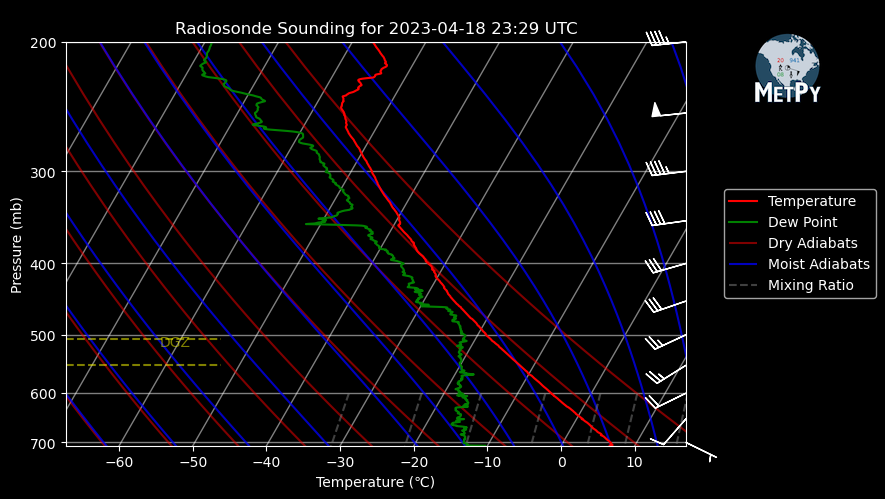

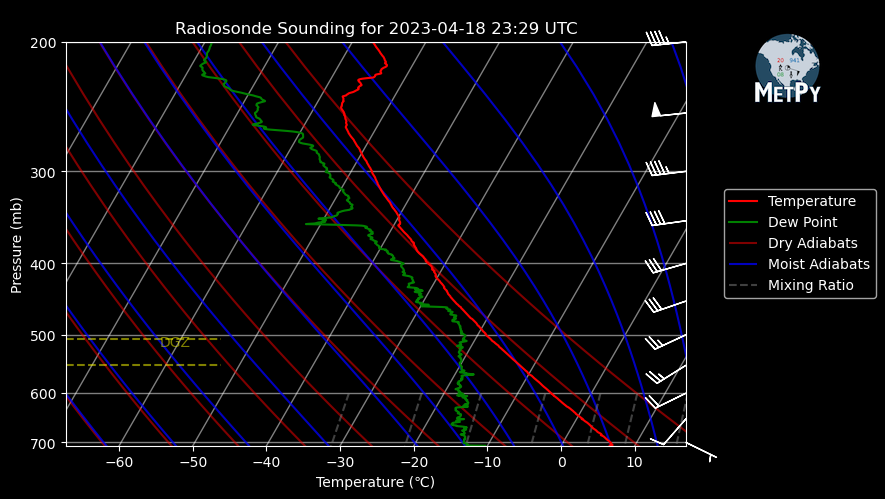

In [69]:
ds_a = xr.open_dataset(files_23[397])
simple_sounding(ds_a)

## Surface - Synoptic Comparison

### 2022 Radiosondes

In [ ]:
kp_sail_22_sondes = kp_sail_22.sel(time=slice('2021-12-01','2022-03-31'))[['wind_spd','wind_dir','mean_q','mean_t','lv']].to_dataframe()
kp_splash_22 = kp_splash_22.sel(time=slice('2021-12-01','2022-03-31'))

kp_sail_22_sondes['sublimation'] = (kp_splash_22['Hl'] * 3600 / kp_sail_22['lv'].mean()).resample(time='12H').sum().to_pandas()
w22_kp_precip = xr.open_dataset('./01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w22.nc')
w22_kp_precip_1D = w22_kp_precip['binary_corrected_prcp_rate_m2'].resample(time='1D').sum().sel(time=slice('2021-12-01','2022-03-31'))
w22_kp_precip_1H = w22_kp_precip_1D.resample(time='1H').ffill()

# fill to match the index of the kp_sos_23_sondes
w22_kp_precip_1H = w22_kp_precip_1H.reindex(time=kp_sail_22_sondes.index)
kp_sail_22_sondes['precip'] = w22_kp_precip_1H.rolling(time=48, center=True).sum()
kp_sail_22_sondes['wind_spd'] = kp_splash_22['wspd_vec_mean'].where(~kp_splash_22['wspd_vec_mean'].isnull(),kp_sail_22_sondes['wind_spd'].values)
kp_sail_22_sondes = kp_sail_22_sondes.resample('12H').agg({'wind_spd': 'first', 'wind_dir': 'first', 'mean_q': 'mean', 'mean_t': 'mean', 'lv': 'mean','precip':'sum'})

sondes_22 = sail_22_radiosonde_ds.sel(time=slice('2021-12-01','2022-04-01')).to_dataframe()
# combine the dataframes
combined_df_22 = kp_sail_22_sondes.join(sondes_22)

# # calculate the dew point temperature
# combined_df_22['dp_temp'] = calc.dewpoint_from_specific_humidity(combined_df_22['mean_t'].values * units("degC"), combined_df_22['mean_q'].values * units("degC").kg / units.kg)
# wspd_fraction
combined_df_22['wspd_fraction'] = (combined_df_22.wind_spd / combined_df_22.wspd)
combined_df_22['wspd_fraction_log'] = combined_df_22['wspd_fraction'].apply(lambda x: np.log10(x))
combined_df_22['wspd_fraction_lognorm'] = (combined_df_22['wspd_fraction_log'] - combined_df_22['wspd_fraction_log'].min()) / (combined_df_22['wspd_fraction_log'].max() - combined_df_22['wspd_fraction_log'].min())

### 2023 Radiosondes

In [72]:
kp_sos_23_sondes = kp_sos_23.sel(time=slice('2022-12-01','2023-04-01'))[['spd_10m_c','dir_10m_c','RH_3m_c','T_3m_c']].to_dataframe()
# add in kettle ponds precipitation
w23_kp_precip = xr.open_dataset('./01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc')
w23_kp_precip_1D = w23_kp_precip['corrected_prcp_rate_m2'].resample(time='1D').sum()
w23_kp_precip_1H = w23_kp_precip_1D.resample(time='1H').ffill()
# fill to match the index of the kp_sos_23_sondes
w23_kp_precip_1H = w23_kp_precip_1H.reindex(time=kp_sos_23_sondes.index)
kp_sos_23_sondes['precip'] = w23_kp_precip_1H.rolling(time=48, center=True).sum()/48
kp_sos_23_sondes = kp_sos_23_sondes.resample('12H').agg({'spd_10m_c': 'first', 'dir_10m_c': 'first', 'RH_3m_c': 'mean', 'T_3m_c': 'mean', 'precip': 'sum'})

# add sublimation
rho_w = 1000 # kg/m^3
g2kg = 1e-3 # g to kg
s_in_hour = 3600 # seconds in an hour
timestep = 12 # hour

# add sublimation
sublimation_12H_ds = xr.open_dataset('./01_data/processed_data/sos/sos_ds_12H_storage.nc')

# calculate the sublimation rate for 1 hour
sublimation_12H = (sublimation_12H_ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o__10m' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour*timestep).to_dataframe().mean(axis=1)
kp_sos_23_sondes['sublimation'] = sublimation_12H

# set the wind speed to the 12H mean
# kp_sos_23_sondes['spd_10m_c'] = sublimation_12H_ds['spd_10m_c'].to_pandas()

sondes_23 = sail_23_radiosonde_ds.sel(time=slice('2022-12-01','2023-04-01')).to_dataframe()

# combine the dataframes
combined_df_23 = kp_sos_23_sondes.join(sondes_23)

# calculate the dew point temperature
combined_df_23['dp_temp'] = calc.dewpoint_from_relative_humidity(combined_df_23['T_3m_c'].values * units.degC, combined_df_23['RH_3m_c'].values * units.percent)
# wspd_fraction
combined_df_23['wspd_fraction'] = (combined_df_23.spd_10m_c / combined_df_23.wspd)
combined_df_23['wspd_fraction_log'] = combined_df_23['wspd_fraction'].apply(lambda x: np.log10(x))
combined_df_23['wspd_fraction_lognorm'] = (combined_df_23['wspd_fraction_log'] - combined_df_23['wspd_fraction_log'].min()) / (combined_df_23['wspd_fraction_log'].max() - combined_df_23['wspd_fraction_log'].min())

# first bin the deg and dir_10m_c into 10 degree bins
combined_df_23['deg_bin'] = pd.cut(combined_df_23.deg, bins=np.arange(0, 375, 15))
combined_df_23['dir_10m_c_bin'] = pd.cut(combined_df_23.dir_10m_c, bins=np.arange(0, 375, 15))
# replace the bins with the left edge
combined_df_23['deg_bin'] = combined_df_23['deg_bin'].apply(lambda x: x.left)
combined_df_23['dir_10m_c_bin'] = combined_df_23['dir_10m_c_bin'].apply(lambda x: float(x.left))

# change the type to float
combined_df_23['deg_bin'] = combined_df_23['deg_bin'].astype('float')
combined_df_23['dir_10m_c_bin'] = combined_df_23['dir_10m_c_bin'].astype('float')


### Combines Pressure Level Data

In [73]:
# get the 600 pres data from combined_df_22
pres_300_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 300].reset_index().set_index('time')
pres_500_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 500].reset_index().set_index('time')
pres_550_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 550].reset_index().set_index('time')
pres_600_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 600].reset_index().set_index('time')
pres_650_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 650].reset_index().set_index('time')
pres_700_23 = combined_df_23[combined_df_23.index.get_level_values('pres') == 700].reset_index().set_index('time')

# get the 600 pres data from combined_df_22
pres_300_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 300].reset_index().set_index('time')
pres_500_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 500].reset_index().set_index('time')
pres_550_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 550].reset_index().set_index('time')
pres_600_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 600].reset_index().set_index('time')
pres_650_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 650].reset_index().set_index('time')
pres_700_22 = combined_df_22[combined_df_22.index.get_level_values('pres') == 700].reset_index().set_index('time')

# Analysis

## Functions

In [74]:
def get_sounding_winds(ds):
    # Filter to only include data below 5000 m
    df = ds[['pres','wspd','u_wind', 'v_wind','alt']].where(ds['alt'] < 5000, drop=True).to_dataframe().reset_index(drop=True)

    # Get the time value
    time = pd.to_datetime(ds.time.values[0])

    # Group by 50 m altitude bins
    df_grouped = df.groupby(pd.cut(df.alt, np.arange(df.alt.min() - 50, df.alt.max(), 50)), observed=True).mean().reset_index(drop=True)
    
    # Limit to first 30 bins
    df_grouped = df_grouped.iloc[:30].copy()
    df_grouped["alt_bin"] = np.arange(df_grouped.shape[0])
    df_grouped = df_grouped.set_index("alt_bin")

    # Convert to xarray Dataset
    ds_out = xr.Dataset.from_dataframe(df_grouped)

    # Add time dimension
    ds_out = ds_out.expand_dims(dim={"time": [time]})

    return ds_out

# Example usage
ds = xr.open_dataset(files_23[397])
sounding_xr = get_sounding_winds(ds)

In [75]:
# create another function to calculate the inversion depth by first changing temperature to potential temperature, and finding the height of the inversion between the surface

def calculate_inversion_depth(ds):
    # group data by 1 hPa bins
    df = ds[['pres','tdry','alt']].to_dataframe().reset_index(drop=True)
    time = pd.to_datetime(ds.time.values[0])
    df['tdry'] = gaussian_filter1d(df.tdry, sigma=2)
    df = df.groupby(pd.cut(df.alt, np.arange(df.alt.min(),df.alt.max(),10, )), observed=True).mean().reset_index(drop=True)

    # calculate the virtual potential temperature
    df['theta'] = calc.potential_temperature(df['pres'].values * units("hectopascal"), df['tdry'].values * units("degC")).magnitude
    
    # calculate the inversion depth
    # lower tropospheric temperature inversions are characterized on the basis of their base height (Zbase), top height (Ztop), depth (deltaZ), and intensity (deltaT) using 
    # methods from Kahl (1990). Zbase in the first level where T startsto increase with height. The inversion is classified as surface based when Zbase is at ground level
    # and as a low level inversion when Z-base is elevated but below the 500-hPa pressure level (Kahl et al, 1992 used 700-hPa as the upper limit for low level inversions in Greenland).
    # Ztop is the altitude aboe the ground level at which T starts to decease with height above Zbase. Thin layers of positive temeprature lapse rates (<100 meters) are considered 
    # to be part of the same inversion layer. Multilayered inversion in high vertical resolution profiles could be calculated but are not applied initially
    # deltaZ is the depth of the inversion layer, and deltaT is the temperature difference between the inversion base and top.

    # create a function to calculate Zbase, Ztop, deltaZ, and deltaT
    T_diff = df.theta.diff()
    # set a threshold for T_diff of 0.01
    # for thin layers of positive temperature lapse rates, make these values positive

    # find the first pressure level where the temperature starts to increase.
    Zbase_idx = T_diff.where(T_diff > 0.05).dropna().index[0]
    # find thin layers of positive temperature lapse rates
    pres_val = df.loc[Zbase_idx, 'pres']
    if Zbase_idx == 1:
        Zbase_idx = 0
    elif pres_val < 500:
        Zbase_idx = np.nan
    # find the first pressure level where the temperature starts to decrease
    if Zbase_idx is not np.nan:
        Ztop_idx = T_diff.where((T_diff.index>Zbase_idx) & (T_diff < 0.05)).dropna().index[0]
        Zbase = df.loc[Zbase_idx, 'alt']
        Ztop = df.loc[Ztop_idx, 'alt']
        deltaZ = Ztop - Zbase
        deltaT = df.loc[Ztop_idx, 'theta'] - df.loc[Zbase_idx, 'theta']
    else:
        Zbase = np.nan
        Ztop = np.nan
        deltaZ = np.nan
        deltaT = np.nan
    return Zbase, Ztop, deltaZ, deltaT, time
# Check for second inversion above the first 

In [76]:
# what percent of soundings have an inversion depth greater than depth_threshold meters and a temperature difference greater than 1 degree
def get_inversion_stats(df):
    # for the morning and afternoon
    depth_threshold = 100
    temp_threshold = 2
    # strong inversions
    df_morning_inversion = df[(df.deltaZ > depth_threshold) & (df.deltaT > temp_threshold) & (df.sounding == 'Morning\n(05:00 MST)')]
    df_afternoon_inversion = df[(df.deltaZ > depth_threshold) & (df.deltaT > temp_threshold) & (df.sounding == 'Afternoon\n(17:00 MST)')]

    # weak inversions all values not in the strong inversion
    df_morning_weak = df.loc[((df.deltaZ <= depth_threshold) | (df.deltaT <= temp_threshold)) & (df.sounding == 'Morning\n(05:00 MST)')]
    df_afternoon_weak = df.loc[((df.deltaZ <= depth_threshold) | (df.deltaT <= temp_threshold)) & (df.sounding == 'Afternoon\n(17:00 MST)')]

    # percent of strong inversions during each season
    morning_strong = len(df_morning_inversion) / len(df[df.sounding == 'Morning\n(05:00 MST)'])
    afternoon_strong = len(df_afternoon_inversion) / len(df[df.sounding == 'Afternoon\n(17:00 MST)'])
    morning_weak = len(df_morning_weak) / len(df[df.sounding == 'Morning\n(05:00 MST)'])
    afternoon_weak = len(df_afternoon_weak) / len(df[df.sounding == 'Afternoon\n(17:00 MST)'])
    # print the inversion percent with 1 decimal place
    print(f'Morning Strong Inversion Percent: {morning_strong:.1%}')
    print(f'Afternoon Strong Inversion Percent: {afternoon_strong:.1%}')
    print(f'Morning Weak Inversion Percent: {morning_weak:.1%}')
    print(f'Afternoon Weak Inversion Percent: {afternoon_weak:.1%}')
    return 


## Concatenate sounding datasets for each year

In [77]:
# Concatenate all the soundings from 2022
data = {}
for i, f in enumerate(files_22):
    try:
        ds = xr.open_dataset(f)
        # get the sounding data
        data[f] = get_sounding_winds(ds)
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue

# Combine all data into single dataset concatenating along the time dimension
sounding_ds_22 = xr.concat(list(data.values()), dim='time')

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220817.113900.cdf


In [78]:
# Concatenate all the soundings from 2023
data = {}
for i, f in enumerate(files_23):
    try:
        ds = xr.open_dataset(f)
        # get the sounding data
        data[f] = get_sounding_winds(ds)
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue

# Combine all data into single dataset concatenating along the time dimension
sounding_ds_23 = xr.concat(list(data.values()), dim='time')

## Inversion Characteristic Calculations for each year

### 2022

In [79]:
data = {}
for i, f in enumerate(files_22):
    try:
        ds = xr.open_dataset(f)
        Zbase, Ztop, deltaZ, deltaT, time = calculate_inversion_depth(ds)
        data[time] = [Zbase, Ztop, deltaZ, deltaT]
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue
# convert to dataframe
df_22 = pd.DataFrame(data).T
# replace the columns
df_22.columns = ['Zbase', 'Ztop', 'deltaZ', 'deltaT']
# if sounding is later than 20:00 and earlier than 03:00, then it is an afternoon sounding
df_22['sounding'] = np.where((df_22.index.hour < 13) & (df_22.index.hour > 6), 'Morning\n(05:00 MST)', 'Afternoon\n(17:00 MST)')

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220314.113200.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220314.115700.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220423.111700.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220423.232700.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220817.113900.cdf


### 2023

In [80]:
%%capture
data = {}
for i, f in enumerate(files_23):
    try:
        ds = xr.open_dataset(f)
        Zbase, Ztop, deltaZ, deltaT, time = calculate_inversion_depth(ds)
        data[time] = [Zbase, Ztop, deltaZ, deltaT]
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue
# convert to dataframe
df_23 = pd.DataFrame(data).T
# replace the columns
df_23.columns = ['Zbase', 'Ztop', 'deltaZ', 'deltaT']
df_23['sounding'] = np.where((df_23.index.hour < 13) & (df_23.index.hour > 6), 'Morning\n(05:00 MST)', 'Afternoon\n(17:00 MST)')

### Seasons

In [81]:
df = pd.concat([df_22, df_23])
# drop any rows where Zbase is > 3500 m
df = df[df.Zbase < 3500]
# with the dataframe make three subplots of Zbase, Ztop, and deltaT,
fig = make_subplots(rows=3, cols=1, subplot_titles=('Zbase', 'deltaZ', 'deltaT'), shared_xaxes=False)

# now just December, January, and February
df_DJF = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)]
# now just JJA
df_JJA = df[(df.index.month == 6) | (df.index.month == 7) | (df.index.month == 8)]
# now MAM
df_MAM = df[(df.index.month == 3) | (df.index.month == 4) | (df.index.month == 5)]
# now SON
df_SON = df[(df.index.month == 9) | (df.index.month == 10) | (df.index.month == 11)]

### Sublimation events

In [82]:
# get the soundings during these dates
df_large_sub_events = df.loc[[datetime_obs for datetime_obs in df.index if datetime_obs.date() in large_sub_events.index.date]]
df_short_sub_events = df.loc[[datetime_obs for datetime_obs in df.index if datetime_obs.date() in short_sub_events.index.date]]
# get the soundings during DJFM 
df_DJFM = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2) | (df.index.month == 3)]
# exclude the large sublimation events from the DJFM soundings
df_DJFM = df_DJFM.loc[~df_DJFM.index.isin(df_large_sub_events.index)]
# exclude the short sublimation events from the DJFM soundings
df_DJFM = df_DJFM.loc[~df_DJFM.index.isin(df_short_sub_events.index)]


# Results

In [83]:
plot_plotly_figs = False

## Inversions across months

In [84]:
if plot_plotly_figs:  
  # Zbase
  fig.add_trace(go.Box(y=df_DJF.Zbase, x=df_DJF.sounding, name='DJF', notched=True, marker_color='blue', offsetgroup='1'), row=1, col=1)
  fig.add_trace(go.Box(y=df_MAM.Zbase, x=df_MAM.sounding, name='MAM', notched=True, marker_color='green', offsetgroup='2'), row=1, col=1)
  fig.add_trace(go.Box(y=df_JJA.Zbase, x=df_JJA.sounding, name='JJA', notched=True, marker_color='red',  offsetgroup='3'), row=1, col=1)
  fig.add_trace(go.Box(y=df_SON.Zbase, x=df_SON.sounding, name='SON', notched=True, marker_color='orange',offsetgroup='4'), row=1, col=1)

  # deltaZ
  fig.add_trace(go.Box(y=df_DJF.deltaZ, x=df_DJF.sounding,dx=0, name='DJF',notched=True,showlegend=False,marker_color='blue', offsetgroup='1'), row=2, col=1)
  fig.add_trace(go.Box(y=df_MAM.deltaZ, x=df_MAM.sounding,dx=0, name='MAM',notched=True,showlegend=False,marker_color='green', offsetgroup='2'), row=2, col=1)
  fig.add_trace(go.Box(y=df_JJA.deltaZ, x=df_JJA.sounding,dx=0, name='JJA',notched=True,showlegend=False,marker_color='red',  offsetgroup='3'), row=2, col=1)
  fig.add_trace(go.Box(y=df_SON.deltaZ, x=df_SON.sounding,dx=0, name='SON',notched=True,showlegend=False,marker_color='orange',offsetgroup='4'), row=2, col=1)

  # deltaT, 
  fig.add_trace(go.Box(y=df_DJF.deltaT, x=df_DJF.sounding,dx=0,name='DJF', notched=True,showlegend=False,marker_color='blue', offsetgroup='1'), row=3, col=1)
  fig.add_trace(go.Box(y=df_MAM.deltaT, x=df_MAM.sounding,dx=0,name='MAM', notched=True,showlegend=False,marker_color='green', offsetgroup='2'), row=3, col=1)
  fig.add_trace(go.Box(y=df_JJA.deltaT, x=df_JJA.sounding,dx=0,name='JJA', notched=True,showlegend=False,marker_color='red',  offsetgroup='3'), row=3, col=1)
  fig.add_trace(go.Box(y=df_SON.deltaT, x=df_SON.sounding,dx=0,name='SON', notched=True,showlegend=False,marker_color='orange', offsetgroup='4'), row=3, col=1)

  fig.update_layout(height=1000, 
                    width=800, 
                    title_text='Inversion Characteristics',
                    boxmode='group',
                    xaxis_zeroline=False,
                    xaxis_title='Sounding Release',
                    yaxis1_title='Zbase (m)',
                      yaxis2_title='deltaZ (m)',
                      yaxis3_title='deltaT (C)',
                      )
                  
  fig.show()


## Inversion characteristics during sublimation events

In [85]:
cdf = pd.concat([df_DJFM.assign(event_type='All Winter Days'),  
                 df_short_sub_events.assign(event_type='Short, Intense Events'),
                 df_large_sub_events.assign(event_type='Long Events'),]).reset_index()
cdf[["event_type", "sounding","deltaT", "deltaZ"]].groupby(['event_type', 'sounding']).mean()

deltaT      deltaZ
event_type            sounding                                    
All Winter Days       Afternoon\n(17:00 MST)  2.993013   97.836893
                      Morning\n(05:00 MST)    7.898166  224.290783
Long Events           Afternoon\n(17:00 MST)  0.973336   50.544365
                      Morning\n(05:00 MST)    2.388502   71.250057
Short, Intense Events Afternoon\n(17:00 MST)  0.858841   42.982066
                      Morning\n(05:00 MST)    6.557711  178.755734

In [86]:
# separate by season
print('DJFM')
get_inversion_stats(df_DJFM)
print("Short, Intense Sublimation Events")
get_inversion_stats(df_short_sub_events)
print("Long Sublimation Events")
get_inversion_stats(df_large_sub_events)



DJFM
Morning Strong Inversion Percent: 63.8%
Afternoon Strong Inversion Percent: 36.7%
Morning Weak Inversion Percent: 36.2%
Afternoon Weak Inversion Percent: 63.3%
Short, Intense Sublimation Events
Morning Strong Inversion Percent: 62.9%
Afternoon Strong Inversion Percent: 2.9%
Morning Weak Inversion Percent: 37.1%
Afternoon Weak Inversion Percent: 97.1%
Long Sublimation Events
Morning Strong Inversion Percent: 23.5%
Afternoon Strong Inversion Percent: 8.7%
Morning Weak Inversion Percent: 76.5%
Afternoon Weak Inversion Percent: 91.3%


## Inversion Characteristics Figure

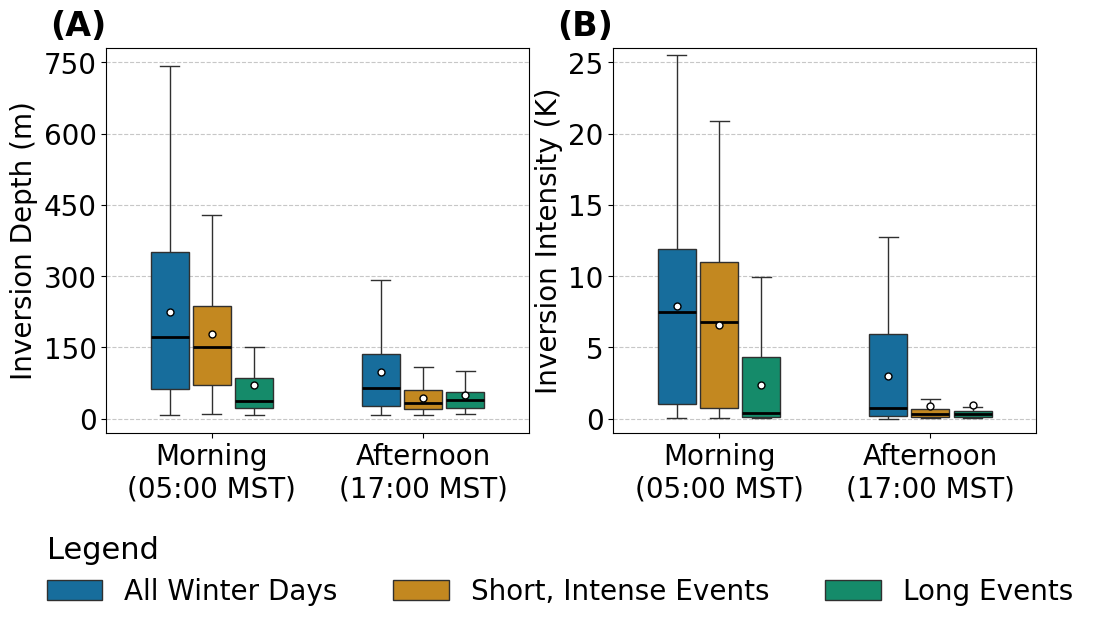

In [87]:
save_fig = True
plt.style.use('default')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Plot the deltaZ
ax = axs[0]
sns.boxplot(x="sounding", y="deltaZ", hue='event_type', data=cdf, 
            ax=ax, 
            palette='colorblind', 
            width=0.6, 
            gap=0.1,
            linewidth=1,
            showfliers=False,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5),
            medianprops=dict(color='black', linewidth=2),
            legend=True,
)
# ax.set_ylim(0,300)
ax.set_ylabel('Inversion Depth (m)', fontsize=20)
ax.set_xlabel('')
ax.set_yticks(np.arange(0, 760, 150))
ax.set_ylim(-30, 780)

ax.text(0, 1.1, '(A)', transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

ax.legend(title='Legend',
          loc='upper left', 
          alignment='left',
          fontsize=20, 
          title_fontsize=22,
          bbox_to_anchor=(-0.2, -0.2),
          frameon=False,
          framealpha=0.8,
          edgecolor='black',
          facecolor='white',
          ncol=3)

# Plot the deltaT
ax = axs[1]
sns.boxplot(x="sounding", y="deltaT", hue='event_type', data=cdf, 
            ax=ax, 
            palette='colorblind', 
            width=0.6, 
            gap=0.1,
            linewidth=1,
            showfliers=False,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5),
            medianprops=dict(color='black', linewidth=2),
            legend=False,
)
# ax.set_ylim(0,20)
ax.set_ylabel('Inversion Intensity (K)', fontsize=20)
ax.set_xlabel('')
ax.text(0, 1.1, '(B)', transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

ax.set_yticks(np.arange(-5, 26, 5))
ax.set_ylim(-1, 26)

for ax in axs:
    # increase the font size of the labels
    ax.tick_params(axis='both', which='major', labelsize=20)
    # increase font size of text 
    ax.title.set_fontsize(20)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
if save_fig:
    # save the figure
    fig.savefig('04_products/figures/draft/inversion_characteristics.png', dpi=300)


### Plotly Plots
ZBase is not as intuitive, removing from this plot.

In [60]:
if plot_plotly_figs:  
  # with the dataframe make three subplots of Zbase, Ztop, and deltaT,
  fig = make_subplots(rows=2, cols=1, 
                      subplot_titles=('ΔZ', 'ΔT'), 
                      shared_xaxes=False, vertical_spacing=0.1)
  # deltaZ
  fig.add_trace(go.Box(y=df_DJFM.deltaZ, x=df_DJFM.sounding,dx=0, name='All Winter (DJFM)',notched=True,showlegend=False,marker_color='blue', offsetgroup='1'), row=1, col=1)
  fig.add_trace(go.Box(y=df_large_sub_events.deltaZ, x=df_large_sub_events.sounding,dx=0, name='Large Sub Events',notched=True,showlegend=True,marker_color='green', offsetgroup='2'), row=1, col=1)
  fig.add_trace(go.Box(y=df_short_sub_events.deltaZ, x=df_short_sub_events.sounding,dx=0, name='Short, Intense Sub Events',notched=True,showlegend=True,marker_color='red', offsetgroup='3'), row=1, col=1)

  # deltaT, 
  fig.add_trace(go.Box(y=df_DJFM.deltaT, x=df_DJFM.sounding,dx=0,name='All Winter (DJFM)', notched=True,showlegend=True,marker_color='blue', offsetgroup='1'), row=2, col=1)
  fig.add_trace(go.Box(y=df_large_sub_events.deltaT, x=df_large_sub_events.sounding,dx=0,name='Large Sub Events', notched=True,showlegend=False,marker_color='green', offsetgroup='2'), row=2, col=1)
  fig.add_trace(go.Box(y=df_short_sub_events.deltaT, x=df_short_sub_events.sounding,dx=0,name='Short, Intense Sub Events', notched=True,showlegend=False,marker_color='red', offsetgroup='3'), row=2, col=1)

  fig.update_layout(height=600, 
                    width=700, 
                    # title_text='Inversion Characteristics',
                    boxmode='group',
                    xaxis_zeroline=False,
                    xaxis2_title='Sounding Release',
                    yaxis1_title='ΔZ (m)',
                    yaxis2_title='ΔT (&deg;C)',
                      )
  # move legend to the top
  fig.update_layout(legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.05,
      xanchor='right',
      x=1
  ))                
  fig.show()

## Surface - Synoptic condition comparison
### Example

Text(0.5, 1.0, 'Geostrophic and Valley Wind Directions')

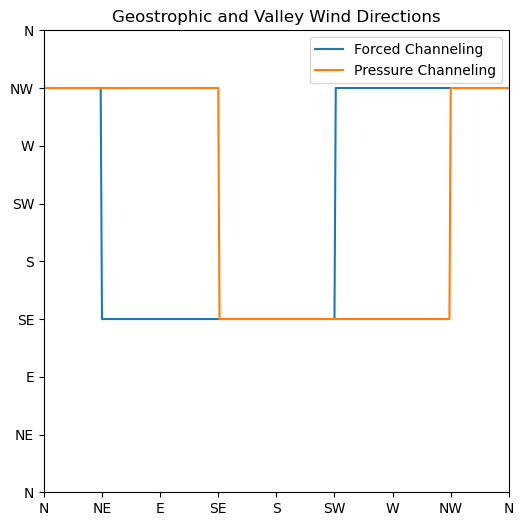

In [ ]:
# Parameters
geostrophic_wind_direction = np.arange(0, 360, 1)  # Geostrophic wind direction array
valley_axis_angle = 135  # Valley oriented northwest to southeast (135 degrees from north)

# Generate valley wind directions
forced_channeling = np.full_like(geostrophic_wind_direction, valley_axis_angle)
pressure_channeling = np.full_like(geostrophic_wind_direction, valley_axis_angle)

# Simulate the relationship based on geostrophic wind direction
for i in range(len(geostrophic_wind_direction)):
    geo_dir = geostrophic_wind_direction[i]
    # Forced channeling: Valley wind aligns with valley axis but shifts when geostrophic wind shifts across normal to valley axis
    if (geo_dir >= (valley_axis_angle - 90)) and (geo_dir <= (valley_axis_angle + 90)):
        forced_channeling[i] = valley_axis_angle
    elif (geo_dir <= (valley_axis_angle - 90)) | (geo_dir >= (valley_axis_angle + 90)):
        forced_channeling[i] = valley_axis_angle + 180
    if (geo_dir >= (valley_axis_angle+180)) and (geo_dir <= (valley_axis_angle)):
        pressure_channeling[i] = valley_axis_angle
    elif (geo_dir <= (valley_axis_angle)) | (geo_dir >= (valley_axis_angle+180)):
        pressure_channeling[i] = valley_axis_angle + 180
plt.figure(figsize=(6, 6))
plt.plot(geostrophic_wind_direction, forced_channeling,label='Forced Channeling')
plt.plot(geostrophic_wind_direction, pressure_channeling,label='Pressure Channeling')
plt.xlim(0, 360)
plt.ylim(0, 360)
# change the x and y ticks to cardinal directions
plt.xticks(np.arange(0, 361, 45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
plt.yticks(np.arange(0, 361, 45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
plt.legend()
plt.title('Geostrophic and Valley Wind Directions')

### Functions

In [ ]:
def add_forced_channeling(geostrophic_wind_direction, forced_channeling, channeling_legend):
    # add black dotted trace for forced channeling 
    forcedchannel = go.Scatter(
        x=geostrophic_wind_direction,
        y=forced_channeling,
        mode='lines',
        line=dict(color='black',dash='dash', width=4),
        showlegend=channeling_legend,
        name='Forced Channeling'
    )
    return forcedchannel

def add_pressure_channeling(geostrophic_wind_direction, pressure_channeling,channeling_legend):
    # add black dotted trace for forced channeling 
    pressurechannel = go.Scatter(
        x=geostrophic_wind_direction,
        y=pressure_channeling,
        mode='lines',
        line=dict(color='black',dash='dot', width=4),
        showlegend=channeling_legend,
        name='Pressure Channeling'
    )
    return pressurechannel

def add_kernel_density(ds, upper_dir, surf_dir, ncontours=20):
    trace500 = go.Histogram2dContour(
        x=ds[upper_dir],
        y=ds[surf_dir],
        colorscale='Blues_r',
        reversescale=True,
        xaxis='x',
        yaxis='y',
        ncontours=ncontours,
        histnorm='percent',
        showscale=True
    )
    # add title to scale
    trace500['colorbar']['x'] = 1.25

In [ ]:
def plot_surface_and_upper_air(ds, level, surf_dir='dir_10m_c', surf_spd='spd_10m_c', surf_temp='T_3m_c', surf_RH='RH_3m_c',upper_dir='deg',upper_spd='wspd', channelling_legend=True):
    # Scatter plot traces (optional for markers)
    scatter500 = go.Scatter(
        x=ds[upper_dir],
        y=ds[surf_dir],
        mode='markers',
        marker=dict(
            size=ds[upper_spd],
            sizemin=5,
            sizemode='diameter',
            sizeref=2. * max(ds[upper_spd]) / (10. **2),
            color=ds[surf_spd],
            colorscale='Viridis',
            opacity=0.7,
            line=dict(width=1, color='black'),
            cmin=0,
            cmax=6
        ),
        showlegend=False,
        name='500 mb'
    )
    # move this colorbar to the right
    scatter500['marker']['colorbar']['x'] = 1.10

    # add forced channeling
    forced_channel = add_forced_channeling(geostrophic_wind_direction, forced_channeling, channelling_legend)
    
    # Create scatter traces for the legend
    fig2 = go.Scatter(
        x=np.zeros(8),
        y=np.array([1, 5, 10, 15, 20, 25, 30, 35]),
        mode='markers',
        marker=dict(
            size=[1, 5, 10, 15, 20, 25, 30, 35],
            sizemin=1,
            sizemode='diameter',
            sizeref=2. * max(ds['wspd']) / (10. **2),
            color='grey',
            opacity=0.5,
            line=dict(width=1, color='black'),
            cmin=0,
            cmax=6
        ),
        showlegend=False,
    )
    # Layout
    layout = go.Layout(
        title=f'Comparing Surface and Radiosonde Winds at {level}',
        xaxis=dict(title=f'Radiosonde Wind Direction at {level}', showgrid=True),
        yaxis=dict(title='Kettle Ponds Wind Direction'),
        width=800,
        height=600,
    )

    # Create figure and plot
    fig = go.Figure(data=[scatter500, forced_channel] + [fig2.update(xaxis="x2", yaxis="y2")], layout=layout)

    # update hovertemplate
    fig.update_traces(
        hovertemplate='Upper Wind Speed: %{marker.size:.2f} m/s<br>Surface Wind Speed: %{marker.color:.2f} m/s<extra></extra>',
    )

    # add vertical and horizontal lines
    v_lines = [0, 45, 90, 135, 180, 225, 270, 315, 360, 405]
    h_lines = v_lines

    for v in v_lines:
        fig.add_shape(type='line', x0=v, x1=v, y0=-10, y1=420, line=dict(color='black', width=1), opacity=0.5)
        # if v == 315:
        #     fig.add_shape(type='line', x0=v, x1=v, y0=-10, y1=420, line=dict(color='blue', width=4, dash='dash'), name='Down-valley', showlegend=True)
        # elif v == 135:
        #     fig.add_shape(type='line', x0=v, x1=v, y0=-10, y1=420, line=dict(color='red', width=4, dash='dash'), name = 'Up-valley', showlegend=True)
    for h in h_lines:
        fig.add_shape(type='line', x0=-10, x1=420, y0=h, y1=h, line=dict(color='black', width=1), opacity=0.5)
        # if h == 315:
        #     fig.add_shape(type='line', x0=-10, x1=420, y0=h, y1=h, line=dict(color='blue', width=4, dash='dash'))
        # elif h == 135:
        #     fig.add_shape(type='line', x0=-10, x1=420, y0=h, y1=h, line=dict(color='red', width=4, dash='dash'))

    # replace x and y labels with cardinal directions
    fig.update_xaxes(tickvals=[0, 90, 180, 270,360],
                    ticktext=['N', 'E','S', 'W', 'N',],
                    range=(0, 365))
    fig.update_yaxes(tickvals=[0, 90, 180, 270,360],
                    ticktext=['N', 'E','S', 'W', 'N',],
                    range=(0, 365))

    # now config axes appropriately
    fig.update_layout(
        xaxis_domain=[0, 0.90],
        xaxis2={"domain": [0.902, 1], "matches": None, "visible": False},
        yaxis2={"anchor": "free", "overlaying": "y", "side": "right", "position": 1, "title": "Upper Air Wind Speed (m/s)"},
        plot_bgcolor='rgba(0,0,0,0)'
    )
    # add the legned
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))

    # add your rotated title via annotations
    fig.update_layout(
        margin=dict(r=150),
        # ^^ making a bit of space for the annotation
        annotations=[
            dict(
                text="Countour Density (%)",
                font_size=15,
                textangle=270,
                showarrow=False,
                # ^^ appearance
                xref="paper",
                yref="paper",
                x=1.4,
                y=0.5,
                # ^^ position
            ),
            dict(
                text="Surface Wind Speed (m/s)",
                font_size=15,
                textangle=270,
                showarrow=False,
                # ^^ appearance
                xref="paper",
                yref="paper",
                x=1.25,
                y=0.5,
                # ^^ position
            ),
        ]
    )
    return fig

In [ ]:
# Sample dataframe with wind directions
# Assuming wind directions are in degrees (0-360)

# Function to convert wind direction to an index between -1 and +1
def wind_index(wind_direction):
    # Shift the wind direction to have -1 at 180 and +1 at 0 and 360
    shifted_direction = (wind_direction -180) % 360
    # Normalize the shifted wind direction to a -1 to +1 scale
    normalized_direction = shifted_direction / 180
    # Apply sine transformation to create the desired index
    index = np.sin(np.deg2rad(normalized_direction * 180)-np.pi/4)
    return index
valley_directions = [135, 315]
normal_directions = [45, 225]

def calculate_index(direction):
    # Calculate the index based on the wind direction
    if direction in valley_directions:
        return 1
    elif direction in normal_directions:
        return 0
    else:
        # Interpolate the index for other directions
        if direction < 45: 
            return np.interp(direction, [0, 45,], [0.5, 0])
        elif direction > 225:
            return np.interp(direction, [225, 270, 315,360], [0, 0.5, 1, 0.5])
        else:
            return np.interp(direction, [0,45, 90, 135, 180, 225], [0.5,0, 0.5,1, 0.5, 0])



### Comparison of surface wind to wind aloft

In [ ]:
# Scatter plots for each pressure_23 level
trace500 = go.Scatter(
    x=pres_500_23['deg'],
    y=pres_500_23['dir_10m_c'],
    mode='markers',
    marker=dict(
        size=10,
        color=pres_500_23['wspd_fraction_lognorm'],
        colorscale='Viridis',
        opacity=0.8,
        line=dict(width=1, color='black'),  # Add black edgecolor
        colorbar=dict(
            title='Wind Speed Fraction',
            tickvals=[0, 0.25, 0.5],
            ticktext=['0', '0.25', '0.5']
        ),
        cmin=0,
        cmax=1
    ),
    name='500 hPa'
)

trace600 = go.Scatter(
    x=pres_600_23['deg'],
    y=pres_600_23['dir_10m_c'],
    mode='markers',
    marker=dict(
        size=10,
        symbol='star',
        color=pres_600_23['wspd_fraction_lognorm'],
        colorscale='Viridis',
        opacity=0.8,
        line=dict(width=1, color='black'),  # Add black edgecolor
        cmin=0,
        cmax=1
    ),
    name='600 hPa'
)

trace700 = go.Scatter(
    x=pres_700_23['deg'],
    y=pres_700_23['dir_10m_c'],
    mode='markers',
    marker=dict(
        size=10,
        symbol='cross',
        color=pres_700_23['wspd_fraction_lognorm'],
        colorscale='Viridis',
        opacity=0.8,
        line=dict(width=1, color='black'),  # Add black edgecolor
        cmin=0,
        cmax=1
    ),
    name='700 hPa'
)

# Layout
layout = go.Layout(
    title='Wind Direction',
    xaxis=dict(title='Radiosonde Wind Direction'),
    yaxis=dict(title='SOS Wind Direction'),
    width=1000,
    height=800,
    legend=dict(x=0.85, y=1)
)
# Create figure and plot
fig = go.Figure(data=[trace500, trace600, trace700], layout=layout)
fig.show()


### Another way to plot surface/aloft conditions

In [ ]:
for df in [pres_500_22, pres_600_22, pres_700_22]:
    # bin wspd into 5 m/s bins
    df['wspd_bin'] = pd.cut(df['wspd'], bins=np.arange(0, 50, 2))
    # replace with the midpoint
    df['wspd_bin'] = df['wspd_bin'].apply(lambda x: x.mid)

In [ ]:
# rename dir_10m_c to wind_dir in
pres_500_23 = pres_500_23.rename(columns={'dir_10m_c': 'wind_dir'})
short_sub_events_moved_22 = short_sub_events_22.resample('12H').mean().dropna(how='all')
short_sub_events_moved_23 = short_sub_events_23.resample('12H').mean().dropna(how='all')

# combine all winter data with large events
pres_500_22_large_events = pres_500_22.loc[large_sub_events_22[large_sub_events_22.index.hour.isin([0, 12])].index]
pres_500_23_large_events = pres_500_23.loc[large_sub_events_23[large_sub_events_23.index.hour.isin([0, 12])].index]
pres_500_22_short_events = pres_500_22.loc[short_sub_events_moved_22[short_sub_events_moved_22.index.hour.isin([0, 12])].index]
pres_500_23_short_events = pres_500_23.loc[short_sub_events_moved_23[short_sub_events_moved_23.index.hour.isin([0, 12])].index]

cdf = pd.concat([pres_500_22.assign(event_type='All Winter Days'), 
                 pres_500_23.assign(event_type='All Winter Days'), 
                 pres_500_22_large_events.assign(event_type='Long Events'), 
                 pres_500_23_large_events.assign(event_type='Long Events'),
                 ]).reset_index()

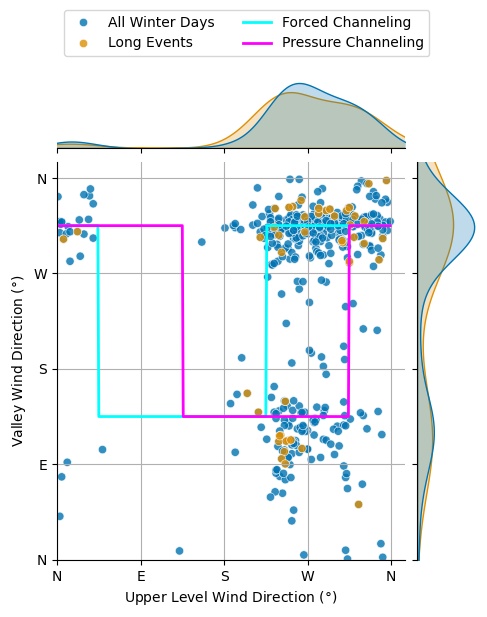

In [27]:
# create a heatmap for each pressure level
g = sns.jointplot(data=cdf, x="deg", y="wind_dir",color='black', alpha=0.8, hue='event_type',
                  marginal_kws=dict(common_norm=False), palette='colorblind', height=6)
plt.plot(geostrophic_wind_direction, forced_channeling, label='Forced Channeling', color='cyan', lw=2)
plt.plot(geostrophic_wind_direction, pressure_channeling, label='Pressure Channeling', color='magenta', lw=2)
# set x and y limits as 0 to 360
g.ax_joint.set_xlim(0, 450)
g.ax_joint.set_ylim(0, 450)
# replace x and y axes every 45 degrees with a degree label
g.ax_joint.set_xticks(np.arange(0, 365, 90))
g.ax_joint.set_yticks(np.arange(0, 365, 90))
# replace the ticklabels with NW,N, NE, E, SE, S, SW, W, NW, N, NW
g.ax_joint.set_xticklabels(['N', 'E', 'S', 'W', 'N'])
g.ax_joint.set_yticklabels(['N', 'E', 'S', 'W', 'N'])
# set the x and y labels
g.ax_joint.set_xlabel('Upper Level Wind Direction ($\degree$)')
g.ax_joint.set_ylabel('Valley Wind Direction ($\degree$)')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# add grid
g.ax_joint.grid(True)

# set xlim and ylim
g.ax_joint.set_xlim(0, 375)
g.ax_joint.set_ylim(0, 375)
plt.legend(title='', bbox_to_anchor=(0.0, 1.4), loc='upper left', ncol=2)


### Putting it together

In [ ]:
level=500
fig1 = plot_surface_and_upper_air(pres_500_22, f'{level} hPa', surf_dir='wind_dir', surf_spd='wind_spd',)
fig2 = plot_surface_and_upper_air(pres_500_23, f'{level} hPa', surf_dir='dir_10m_c', surf_spd='spd_10m_c',channelling_legend=False)

# combine the figures
fig = fig1.add_traces(fig2.data)

fig.show()

In [145]:
fig1 = plot_surface_and_upper_air(pres_500_22.loc[large_sub_events_22[large_sub_events_22.index.hour.isin([0, 12])].index], f'{level} hPa', surf_dir='wind_dir', surf_spd='wind_spd')
fig2 = plot_surface_and_upper_air(pres_500_23.loc[large_sub_events_23[large_sub_events_23.index.hour.isin([0, 12])].index], f'{level} hPa', surf_dir='dir_10m_c', surf_spd='spd_10m_c',channelling_legend=False)

# combine the figures
fig1.add_traces(fig2.data)

### Correlation between variables

In [ ]:
pres_ds = pres_600_23
pres_ds['downvalley_wind_index'] = pres_ds['deg'].apply(wind_index)

# add dew point depression
pres_ds['dpd_surface'] = pres_ds['T_3m_c'] - pres_ds['dp_temp']
pres_ds['dpd_aloft'] = pres_ds['tdry'] - pres_ds['dp']
# plot dew point depression at surface against aloft
df_subset_1 = pres_ds[(pres_ds['spd_10m_c'] < 2)& (pres_ds['precip'] > 1) ]
df_subset_2 = pres_ds[(pres_ds['spd_10m_c'] >= 2) & (pres_ds['precip'] > 1)]
light_winds_precip_df = df_subset_1[['spd_10m_c','precip','sublimation','alt','u_wind','v_wind','dpd_aloft','tdry','wspd','RH_3m_c', 'T_3m_c']]
windy_precip_df = df_subset_2[['spd_10m_c','precip','sublimation','alt','u_wind','v_wind','dpd_aloft','tdry','wspd','RH_3m_c', 'T_3m_c']]

# plot variables against each other
windy_precip_df.corr()

,spd_10m_c,precip,sublimation,alt,u_wind,v_wind,dpd_aloft,tdry,wspd,RH_3m_c,T_3m_c
spd_10m_c,1.000000,0.121856,0.648783,-0.251490,0.018638,-0.329325,-0.052606,-0.310764,0.136272,-0.266360,-0.027856
precip,0.121856,1.000000,0.146742,-0.176885,0.261039,0.196912,-0.199885,0.107016,0.128817,0.319280,0.426634
sublimation,0.648783,0.146742,1.000000,-0.088749,0.163672,-0.147107,-0.080125,-0.160428,0.103763,-0.450249,0.249109
alt,-0.251490,-0.176885,-0.088749,1.000000,0.159856,-0.162269,0.345588,0.386296,0.221397,-0.212310,-0.064768
u_wind,0.018638,0.261039,0.163672,0.159856,1.000000,0.129477,-0.000273,0.222963,0.716768,-0.077502,0.168762
v_wind,-0.329325,0.196912,-0.147107,-0.162269,0.129477,1.000000,-0.059018,0.279242,-0.040660,0.128382,0.231489
dpd_aloft,-0.052606,-0.199885,-0.080125,0.345588,-0.000273,-0.059018,1.000000,0.209331,-0.017635,-0.016860,-0.242820
tdry,-0.310764,0.107016,-0.160428,0.386296,0.222963,0.279242,0.209331,1.000000,0.280543,0.042391,0.311969
wspd,0.136272,0.128817,0.103763,0.221397,0.716768,-0.040660,-0.017635,0.280543,1.000000,-0.062002,0.103030
RH_3m_c,-0.266360,0.319280,-0.450249,-0.212310,-0.077502,0.128382,-0.016860,0.042391,-0.062002,1.000000,0.054377
